https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"

pd.set_option("display.max_columns", 2000)

import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
app_train = pd.read_csv(path + "application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [5]:
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [6]:
pcb = pd.read_csv(path + "POS_CASH_balance.csv")
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [7]:
previous_application = pd.read_csv(path + "previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
installments_payments = pd.read_csv(path + "installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 学習データ準備

In [9]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

# read the test files 
app_test = pd.read_csv('../input/application_test.csv')


# Remove some rows with values not present in test set
#app_train.drop(app_train[app_train['CODE_GENDER'] == 'XNA'].index, inplace = True)
#app_train.drop(app_train[app_train['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
#app_train.drop(app_train[app_train['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
app_train['bur NAN num'] = app_train.isnull().sum(axis = 1).values
app_test['bur NAN num'] = app_test.isnull().sum(axis = 1).values


app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### <a id="0.1">0.1 Prepare - Data Cleaning</a>

In [10]:
    
# Remove some empty features
data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
# Replace some outliers
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
data.loc[data['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
data.loc[data['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
data.loc[data['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
data.loc[data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
data.loc[data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan

In [11]:
# 割合別
data['app self cate OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace({'High skill tech staff':'High_Skill',
                                    'Managers':0,
                                    'Accountants':0,
                                    'HR staff':0,
                                    'Core staff':0,
                                   'Cooking staff':1,
                                    'Realty agents':0,
                                    'Sales staff':1,
                                    'IT staff':0,
                                    'Medicine staff':0,
                                    'Secretaries':0,
                                    'Security staff':1,
                                    'Cleaning staff':1,
                                      'Laborers':1,
                                      'Low-skill Laborers':1,
                                      'Cleaning staff':1,
                                    'Waiters/barmen staff':1,
                                    'Private service staff':0,
                                    'Drivers':1,
                                    'High skill tech staff':0                                                                       
                                   },inplace=False)

data['app self cate NAME_INCOME_TYPE'] = data['NAME_INCOME_TYPE'].replace(
                        {'Businessman':0,
                         'Student':0,
                         'Unemployed':1,
                         'Working':1,
                         'Commercial associate':0,                        
                         'State servant':0,
                         'Pensioner':0,                         
                         'Maternity leave':1}
                        ,inplace=False)

data['app self cate NAME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].replace(
                        {'Rented apartment':1,
                         'With parents':1,
                         'Municipal apartment':0,
                         'Co-op apartment':0,
                         'House / apartment':0,                        
                         'Office apartment':0}
                        ,inplace=False)

data['app self cate ORGANIZATION_TYPE'] = data['ORGANIZATION_TYPE'].replace(
{'Transport':1, 
'Industry: type 13':1, 
'Industry: type 8':1, 
'Restaurant':1, 
'Construction':1,
'Cleaning':1,
'Industry: type 1':1,
'Industry: type 3':1,
'Realtor':1,
'Agriculture':1,
'Trade: type 3':1,
'Self-employed':1,
'Industry: type 4':1,
'Security':0,
'Trade: type 7':0,
'Business Entity Type 3':0,
'Transport: type 4':0,
'Mobile':0,
'Trade: type 1':0,
'Industry: type 11':0,
'Business Entity Type 2':0,
'Postal':0,
'Advertising':0,
'Business Entity Type 1':0,
'Industry: type 7':0,
'Housing':0,
'Legal Services':0,
'Transport: type 2':0,
'Other':0,
'Telecom':0,
'Industry: type 2':0,
'Industry: type 6':0,
'Emergency':0,
'Kindergarten':0,
'Trade: type 2':0,
'Government':0,
'Industry: type 5':0,
'Industry: type 9':0,
'Electricity':0,
'Services':0,
'Medicine':0,
'Industry: type 10':0,
'Hotel':0,
'Trade: type 5':0,
'School':0,
'Religion':0,
'Insurance':0,
'Culture':0,
'XNA':0,
'Bank':0,
'Military':0,
'Police':0,
'University':0,
'Security Ministries':0,
'Trade: type 6':0,
'Transport: type 1':0,
'Industry: type 12':0,
'Trade: type 4':0}
                        ,inplace=False)

### <a id="0.2">0.2 Prepare - Categorical Data Processing</a>

In [12]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(pcb)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(pcb, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

## feature engineering

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [13]:

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['pre SK_ID_PREV_CNT'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
previous_application.drop(['SK_ID_PREV'], axis = 1, inplace = True)


# Days 365.243 values -> nan
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# nan num
previous_application['pre NAN num'] = previous_application.isnull().sum(axis = 1).values

# Add feature: value ask / value received percentage
previous_application['pre AMT_APPLICATION / AMT_CREDIT'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
previous_application['pre loan AMT_APPLICATION / AMT_CREDIT'] = previous_application['NAME_CONTRACT_TYPE_Cash loans'] * previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
previous_application['pre revo AMT_APPLICATION / AMT_CREDIT'] = previous_application['NAME_CONTRACT_TYPE_Revolving loans'] * previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']

previous_application['pre loan AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Cash loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
previous_application['pre con loan AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Consumer loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
previous_application['pre revo AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Revolving loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['pre ' + col + '_mean' for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
del prev_apps_avg
gc.collect()

# Previous applications numeric features
num_aggregations = {
        'AMT_ANNUITY': ['max'],
        'AMT_APPLICATION': ['max'],
        'AMT_CREDIT': ['max', 'sum'],
        'pre AMT_APPLICATION / AMT_CREDIT': ['max'],
        'AMT_DOWN_PAYMENT': ['max'],
        'AMT_GOODS_PRICE': ['max'],
        'HOUR_APPR_PROCESS_START': ['max'],
        'RATE_DOWN_PAYMENT': ['max'],
        'DAYS_DECISION': ['max'],
        'CNT_PAYMENT': ['sum'],
}

cat_aggregations = {}

prev_agg = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['pre ' + e[0] for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['pre APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['pre REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_done = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg
gc.collect()

data = data.merge(right=prev_done.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [14]:
bureau['bur NAN num'] = bureau.isnull().sum(axis = 1).values
bureau_balance['bur_bal NAN num'] = bureau_balance.isnull().sum(axis = 1).values

# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['bur CNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['bur ' + f_ + '_mean' for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
del bureau_avg
gc.collect()

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bureau_balance, bb_agg
gc.collect()

# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean', 'max'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['max', 'sum', 'mean']
}

# Bureau and bureau_balance categorical features
cat_aggregations = {}
 
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['bur_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['bur_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['bur_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau
gc.collect()

data = data.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [15]:
installments_payments['ins NAN num'] = installments_payments.isnull().sum(axis = 1).values

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['ins ' + f_ + '_mean' for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
del avg_inst
gc.collect()

## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['ins_SK_ID_PREV_CNT'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])
installments_payments.drop(['SK_ID_PREV'], axis = 1, inplace = True)


# Percentage and difference paid in each installment (amount paid and installment value)
installments_payments['ins AMT_PAYMENT / AMT_INSTALMENT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['ins AMT_INSTALMENT / AMT_PAYMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

# Days past due and days before due (no negative values)
installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'].apply(lambda x: x if x > 0 else 0)
installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'].apply(lambda x: x if x > 0 else 0)

# Features: Perform aggregations
aggregations = {
     'NUM_INSTALMENT_VERSION': ['nunique'],
     'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT': ['max', 'sum','min','std' ],
     'ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT': ['max', 'sum','min','std'],
     'ins AMT_PAYMENT / AMT_INSTALMENT': [ 'max', 'var','min','std'],
     'ins AMT_INSTALMENT / AMT_PAYMENT': [ 'max', 'var','min','std'],
     'AMT_INSTALMENT': ['max', 'sum','min','std'],
     'AMT_PAYMENT': ['min', 'max', 'sum','std'],
     'DAYS_ENTRY_PAYMENT': ['max', 'sum','std']
}
ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['ins ' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Count installments accounts
ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
del installments_payments
gc.collect()

data = data.merge(right=ins_agg.reset_index(), how='left', on='SK_ID_CURR')



### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [16]:
pcb['pcb NAN num'] = pcb.isnull().sum(axis = 1).values

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
del pcb_avg
gc.collect()

#
pos_cash_sorted = pcb.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
group_object.rename(index=str, columns={'CNT_INSTALMENT_FUTURE': 'pcb cash_remaining_installments'}, inplace=True)
data = data.merge(group_object, on=['SK_ID_CURR'], how='left')


pcb['is_contract_status_completed'] = pcb['NAME_CONTRACT_STATUS'] == 'Completed'
group_object = pcb.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
group_object.rename(index=str,
                    columns={'is_contract_status_completed': 'pcb cash_completed_contracts'},
                    inplace=True)
data = data.merge(group_object, on=['SK_ID_CURR'], how='left')




In [17]:

def last_k_installment_features(dt, periods):
    
    features = {}
    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = pcb[(pcb['MONTHS_BALANCE'] < period)].groupby(['SK_ID_CURR'])
            
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)

        pd_features = pd.DataFrame(features)
        #pd_features.index = indeces
        pd_features.index.name = 'SK_ID_CURR'
        
        return pd_features


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]  
    gr_ = gr_.groupby(['SK_ID_CURR'])
        
    features={}
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    pd_features = pd.DataFrame(features)
    #pd_features.index = indeces
    pd_features.index.name = 'SK_ID_CURR'   
    
    return pd_features




In [18]:
pcb['pcb cash_paid_late'] = (pcb['SK_DPD'] > 0).astype(int)
pcb['pcb cash_paid_late_with_tolerance'] = (pcb['SK_DPD_DEF'] > 0).astype(int)


with timer('unique'):
    features = pd.DataFrame({'SK_ID_CURR': pcb['SK_ID_CURR'].unique()})
    
with timer('last_k'):    
    g = last_k_installment_features(pcb, periods=[-1, -10, -30, -50])
    features = features.merge(g, on='SK_ID_CURR', how='left')
    data = data.merge(features, on='SK_ID_CURR', how='left')
    
with timer('last_loan_features'):    
    g = last_loan_features(pcb)
    data = data.merge(g, on='SK_ID_CURR', how='left')



unique - done in 0s
last_k - done in 14s
last_loan_features - done in 12s


In [19]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bur NAN num,is_test,is_train,app self cate OCCUPATION_TYPE,app self cate NAME_INCOME_TYPE,app self cate NAME_HOUSING_TYPE,app self cate ORGANIZATION_TYPE,pre AMT_ANNUITY_mean,pre AMT_APPLICATION_mean,pre AMT_CREDIT_mean,pre AMT_DOWN_PAYMENT_mean,pre AMT_GOODS_PRICE_mean,pre HOUR_APPR_PROCESS_START_mean,pre NFLAG_LAST_APPL_IN_DAY_mean,pre RATE_DOWN_PAYMENT_mean,pre RATE_INTEREST_PRIMARY_mean,pre RATE_INTEREST_PRIVILEGED_mean,pre DAYS_DECISION_mean,pre SELLERPLACE_AREA_mean,pre CNT_PAYMENT_mean,pre DAYS_FIRST_DRAWING_mean,pre DAYS_FIRST_DUE_mean,pre DAYS_LAST_DUE_1ST_VERSION_mean,pre DAYS_LAST_DUE_mean,pre DAYS_TERMINATION_mean,pre NFLAG_INSURED_ON_APPROVAL_mean,pre NAME_CONTRACT_TYPE_Cash loans_mean,pre NAME_CONTRACT_TYPE_Consumer loans_mean,pre NAME_CONTRACT_TYPE_Revolving loans_mean,pre NAME_CONTRACT_TYPE_XNA_mean,pre WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,pre WEEKDAY_APPR_PROCESS_START_MONDAY_mean,pre WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,pre WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,pre WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,pre WEEKDAY_APPR_PROCESS_START_TUESDAY_mean,pre WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,pre FLAG_LAST_APPL_PER_CONTRACT_N_mean,pre FLAG_LAST_APPL_PER_CONTRACT_Y_mean,pre NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,pre NAME_CASH_LOAN_PURPOSE_Business development_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a home_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a used car_mean,pre NAME_CASH_LOAN_PURPOSE_Car repairs_mean,pre NAME_CASH_LOAN_PURPOSE_Education_mean,pre NAME_CASH_LOAN_PURPOSE_Everyday expenses_mean,pre NAME_CASH_LOAN_PURPOSE_Furniture_mean,pre NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,pre NAME_CASH_LOAN_PURPOSE_Hobby_mean,pre NAME_CASH_LOAN_PURPOSE_Journey_mean,pre NAME_CASH_LOAN_PURPOSE_Medicine_mean,pre NAME_CASH_LOAN_PURPOSE_Money for a third person_

In [20]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
pcb.drop(['SK_ID_PREV'], axis = 1, inplace = True)

# Features
aggregations = {
     'MONTHS_BALANCE': ['mean', 'max', 'min', 'sum', 'var', 'size'],
     'CNT_INSTALMENT' : ['mean', 'max'],
     'CNT_INSTALMENT_FUTURE' : ['mean', 'max'],
     'SK_DPD': ['mean', 'max', 'min', 'sum', 'var'],
     'SK_DPD_DEF': ['mean', 'max', 'min', 'sum', 'var']
}


pos_agg = pcb.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['pcb ' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pcb.groupby('SK_ID_CURR').size()
del pcb
gc.collect()

data = data.merge(right=pos_agg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [21]:

# No of Loans per customer 

CCB = credit_card_balance[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'cre NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

# No of Installments paid per Loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'cre NO_INSTALMENTS'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['cre NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'cre NO_INSTALMENTS': 'cre TOTAL_INSTALMENTS'})
CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

# Average Number of installments paid per loan 

CCB['cre INSTALLMENTS_PER_LOAN'] = (CCB['cre TOTAL_INSTALMENTS']/CCB['cre NO_LOANS']).astype('uint32')
del CCB['cre TOTAL_INSTALMENTS']
del CCB['cre NO_LOANS']
gc.collect()



21

In [22]:

CCB['AMT_CREDIT_LIMIT_ACTUAL1'] = CCB['AMT_CREDIT_LIMIT_ACTUAL']

def f(x1, x2):
    
    balance = x1.max()
    limit = x2.max()
    
    return (balance/limit)

# Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
# This is done for each Credit limit value per loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: f(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
del CCB['AMT_CREDIT_LIMIT_ACTUAL1']
gc.collect()

# We now calculate the mean Credit load of All Loan transactions of Customer 
grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'cre CREDIT_LOAD'})
print(grp1.dtypes)

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()



SK_ID_CURR           int64
cre CREDIT_LOAD    float64
dtype: object


49

In [23]:

def f(DPD):
    
    # DPD is a series of values of SK_DPD for each of the groupby combination 
    # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
    x = DPD.tolist()
    c = 0
    for i,j in enumerate(x):
        if j != 0:
            c += 1
    
    return c 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: f(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'cre DPD_COUNT'})

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp1
del grp 
gc.collect()


70

In [24]:
grp = CCB.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'cre AVG_DPD'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

42

In [25]:

def f(min_pay, total_pay):
    
    M = min_pay.tolist()
    T = total_pay.tolist()
    P = len(M)
    c = 0 
    # Find the count of transactions when Payment made is less than Minimum Payment 
    for i in range(len(M)):
        if T[i] < M[i]:
            c += 1  
    return (100*c)/P

grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'cre PERCENTAGE_MISSED_PAYMENTS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

58

In [26]:
grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'cre DRAWINGS_ATM'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre DRAWINGS_TOTAL'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['cre CASH_CARD_RATIO1'] = (CCB['cre DRAWINGS_ATM']/CCB['cre DRAWINGS_TOTAL'])*100
del CCB['cre DRAWINGS_ATM']
del CCB['cre DRAWINGS_TOTAL']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['cre CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre CASH_CARD_RATIO1' : 'cre CASH_CARD_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['cre CASH_CARD_RATIO1']
gc.collect()

7

In [27]:
grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre TOTAL_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'cre NO_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['cre DRAWINGS_RATIO1'] = (CCB['cre TOTAL_DRAWINGS']/CCB['cre NO_DRAWINGS'])*100
del CCB['cre TOTAL_DRAWINGS']
del CCB['cre NO_DRAWINGS']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['cre DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre DRAWINGS_RATIO1' : 'cre DRAWINGS_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['cre DRAWINGS_RATIO1']

In [28]:
credit_card_balance['cre NAN num'] = credit_card_balance.isnull().sum(axis = 1).values

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ + '_mean' for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
del avg_cc_bal
gc.collect()

### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['cre_SK_ID_PREV_CNT'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)

# General aggregations
cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg([ 'max', 'sum', 'var'])
cc_agg.columns = pd.Index(['cre_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
data = data.merge(right=cc_agg.reset_index(), how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()


77

### <a id="1.6">1.6 Feature Engineering - app </a>

In [30]:
data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app AMT_CREDIT / AMT_ANNUITY / DAYS_EMPLOYED'] = data['app AMT_CREDIT / AMT_ANNUITY'] / data['DAYS_EMPLOYED']

data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']

data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
  
# loan 別
data['app rebo AMT_CREDIT / AMT_INCOME_TOTAL'] = data['NAME_CONTRACT_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app loan AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app AMT_CREDIT / AMT_INCOME_TOTAL'] - data['app rebo AMT_CREDIT / AMT_INCOME_TOTAL']
data['app rebo AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['NAME_CONTRACT_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app loan AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] - data['app rebo AMT_ANNUITY / AMT_INCOME_TOTAL']
data['app rebo AMT_CREDIT / AMT_ANNUITY'] = data['NAME_CONTRACT_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app loan AMT_CREDIT / AMT_ANNUITY'] = data['app AMT_CREDIT / AMT_ANNUITY'] - data['app rebo AMT_CREDIT / AMT_ANNUITY']
data['app rebo DAYS_EMPLOYED / DAYS_BIRTH'] = data['NAME_CONTRACT_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['app loan DAYS_EMPLOYED / DAYS_BIRTH'] = data['app DAYS_EMPLOYED / DAYS_BIRTH'] - data['app rebo DAYS_EMPLOYED / DAYS_BIRTH']

data['app missing'] = data.isnull().sum(axis = 1).values
    
data['app EXT_SOURCE mean'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
data['app EXT_SOURCE std'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
data['app EXT_SOURCE prod'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = data['EXT_SOURCE_1'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = data['EXT_SOURCE_2'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = data['EXT_SOURCE_3'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_1 / DAYS_BIRTH'] = data['EXT_SOURCE_1'] / data['DAYS_BIRTH']
data['app EXT_SOURCE_2 / DAYS_BIRTH'] = data['EXT_SOURCE_2'] / data['DAYS_BIRTH']
data['app EXT_SOURCE_3 / DAYS_BIRTH'] = data['EXT_SOURCE_3'] / data['DAYS_BIRTH']
  
data['app AMT_CREDIT - AMT_GOODS_PRICE'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
data['app AMT_CREDIT / AMT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
  
data['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / 12. - data['AMT_ANNUITY']
data['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / data['AMT_ANNUITY']
data['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = data['AMT_INCOME_TOTAL'] - data['AMT_GOODS_PRICE']
data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])
    
data['app most popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
data['app popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
data['app OWN_CAR_AGE / DAYS_BIRTH'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['app OWN_CAR_AGE / DAYS_EMPLOYED'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    
data['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
data['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
data['app DAYS_EMPLOYED - DAYS_BIRTH'] = data['DAYS_EMPLOYED'] - data['DAYS_BIRTH']
data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    
data['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']

data['app OBS_30_CNT_SOCIAL_CIRCLE - DEF_30_CNT_SOCIAL_CIRCLE'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] - data['DEF_30_CNT_SOCIAL_CIRCLE']
data['app OBS_60_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] - data['DEF_60_CNT_SOCIAL_CIRCLE']
data['app DAYS_EMPLOYED - DAYS_REGISTRATION'] = data['DAYS_EMPLOYED'] - data['DAYS_REGISTRATION']
data['app DAYS_EMPLOYED - DAYS_ID_PUBLISH'] = data['DAYS_EMPLOYED'] - data['DAYS_ID_PUBLISH']

data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['app CNT_CHILDREN / CNT_CHILDREN'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
    
data['app TOTAL_DOCS_SUBMITTED'] = data.loc[:, data.columns.str.contains('FLAG_DOCUMENT')].sum(axis=1)

In [31]:
# app self cate OCCUPATION_TYPE
data['app self cate occ AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app self cate occ AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app self cate occ AMT_CREDIT / AMT_ANNUITY'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app self cate occ DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate OCCUPATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

# app self cate NAME_INCOME_TYPE
data['app self cate income AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app self cate income AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app self cate income AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app self cate income DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_INCOME_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

# app self cate NAME_HOUSING_TYPE
data['app self cate housing AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app self cate housing AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app self cate housing AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app self cate housing DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_HOUSING_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

# app self cate ORGANIZATION_TYPE
data['app self cate org AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app self cate org AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app self cate org AMT_CREDIT / AMT_ANNUITY'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app self cate org DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate ORGANIZATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']


### <a id="1.7">1.7 Feature Engineering - PolyFeature </a>

In [32]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

# Create a dataframe of the features 
pd_poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH']))
pd_poly_features = pd_poly_features.drop(columns =['1', 'POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH'])
data_reset = data.reset_index()
pd_poly_features['SK_ID_CURR'] = data_reset['SK_ID_CURR'] 
data = data.merge(pd_poly_features, on = 'SK_ID_CURR', how = 'left')

Polynomial Features shape:  (356255, 35)


### <a id="2.0">2.0 Prepare Final Train and Test data</a>

In [33]:
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [34]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bur NAN num,is_test,is_train,app self cate OCCUPATION_TYPE,app self cate NAME_INCOME_TYPE,app self cate NAME_HOUSING_TYPE,app self cate ORGANIZATION_TYPE,pre AMT_ANNUITY_mean,pre AMT_APPLICATION_mean,pre AMT_CREDIT_mean,pre AMT_DOWN_PAYMENT_mean,pre AMT_GOODS_PRICE_mean,pre HOUR_APPR_PROCESS_START_mean,pre NFLAG_LAST_APPL_IN_DAY_mean,pre RATE_DOWN_PAYMENT_mean,pre RATE_INTEREST_PRIMARY_mean,pre RATE_INTEREST_PRIVILEGED_mean,pre DAYS_DECISION_mean,pre SELLERPLACE_AREA_mean,pre CNT_PAYMENT_mean,pre DAYS_FIRST_DRAWING_mean,pre DAYS_FIRST_DUE_mean,pre DAYS_LAST_DUE_1ST_VERSION_mean,pre DAYS_LAST_DUE_mean,pre DAYS_TERMINATION_mean,pre NFLAG_INSURED_ON_APPROVAL_mean,pre NAME_CONTRACT_TYPE_Cash loans_mean,pre NAME_CONTRACT_TYPE_Consumer loans_mean,pre NAME_CONTRACT_TYPE_Revolving loans_mean,pre NAME_CONTRACT_TYPE_XNA_mean,pre WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,pre WEEKDAY_APPR_PROCESS_START_MONDAY_mean,pre WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,pre WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,pre WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,pre WEEKDAY_APPR_PROCESS_START_TUESDAY_mean,pre WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,pre FLAG_LAST_APPL_PER_CONTRACT_N_mean,pre FLAG_LAST_APPL_PER_CONTRACT_Y_mean,pre NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,pre NAME_CASH_LOAN_PURPOSE_Business development_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a home_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,pre NAME_CASH_LOAN_PURPOSE_Buying a used car_mean,pre NAME_CASH_LOAN_PURPOSE_Car repairs_mean,pre NAME_CASH_LOAN_PURPOSE_Education_mean,pre NAME_CASH_LOAN_PURPOSE_Everyday expenses_mean,pre NAME_CASH_LOAN_PURPOSE_Furniture_mean,pre NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,pre NAME_CASH_LOAN_PURPOSE_Hobby_mean,pre NAME_CASH_LOAN_PURPOSE_Journey_mean,pre NAME_CASH_LOAN_PURPOSE_Medicine_mean,pre NAME_CASH_LOAN_PURPOSE_Money for a third person_

In [36]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
max_score = -100
max_params = None

#all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
#          'learning_rate': [0.01], 'num_leaves': [64,200], 'num_iteration': [5000, 8989], 'verbose': [0] ,
#          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[5,7,8], 'reg_alpha':[0.1], 'reg_lambda':[0.1, 2.6900], 
#          'min_split_gain':[0.01], 'min_child_weight':[1, 1.3459]}

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.01], 'num_leaves': [64], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[8], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
          'min_split_gain':[0.01], 'min_child_weight':[1.3459]}


list_auc_score = []
list_preds = []

for params in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        #lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        #lgb_eval = lgb.Dataset(data=val_x, label=val_y)
        #model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        #preds_val = model.predict(val_x)
        #preds = model.predict(testX)       
        
        clf = lgb.sklearn.LGBMClassifier(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='auc'
                )        
        preds_val = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        preds = clf.predict_proba(testX, num_iteration=clf.best_iteration_)[:, 1]
        
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        list_preds.append(preds)
        
        if (max_score < auc):
            max_score = auc
            max_params = params
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score, params)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.720422
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.727183
[3]	valid_0's auc: 0.729296
[4]	valid_0's auc: 0.730452
[5]	valid_0's auc: 0.730359
[6]	valid_0's auc: 0.731838
[7]	valid_0's auc: 0.73175
[8]	valid_0's auc: 0.733303
[9]	valid_0's auc: 0.734031
[10]	valid_0's auc: 0.734665
[11]	valid_0's auc: 0.734795
[12]	valid_0's auc: 0.735011
[13]	valid_0's auc: 0.735081
[14]	valid_0's auc: 0.736377
[15]	valid_0's auc: 0.737
[16]	valid_0's auc: 0.737823
[17]	valid_0's auc: 0.738001
[18]	valid_0's auc: 0.738281
[19]	valid_0's auc: 0.738758
[20]	valid_0's auc: 0.739187
[21]	valid_0's auc: 0.739375
[22]	valid_0's auc: 0.739184
[23]	valid_0's auc: 0.739416
[24]	valid_0's auc: 0.739839
[25]	valid_0's auc: 0.739879
[26]	valid_0's auc: 0.739959
[27]	valid_0's auc: 0.74009
[28]	valid_0's auc: 0.740228
[29]	valid_0's auc: 0.740419
[30]	valid_0's auc: 0.740522
[31]	valid_0's auc: 0.741105
[32]	valid_0's auc: 0.741564
[33]	valid_0's auc: 0.7

[276]	valid_0's auc: 0.768637
[277]	valid_0's auc: 0.768728
[278]	valid_0's auc: 0.768792
[279]	valid_0's auc: 0.768879
[280]	valid_0's auc: 0.768951
[281]	valid_0's auc: 0.769026
[282]	valid_0's auc: 0.76911
[283]	valid_0's auc: 0.769179
[284]	valid_0's auc: 0.769259
[285]	valid_0's auc: 0.76932
[286]	valid_0's auc: 0.769357
[287]	valid_0's auc: 0.769444
[288]	valid_0's auc: 0.769492
[289]	valid_0's auc: 0.769572
[290]	valid_0's auc: 0.76966
[291]	valid_0's auc: 0.769726
[292]	valid_0's auc: 0.769777
[293]	valid_0's auc: 0.769831
[294]	valid_0's auc: 0.769902
[295]	valid_0's auc: 0.769939
[296]	valid_0's auc: 0.770006
[297]	valid_0's auc: 0.770074
[298]	valid_0's auc: 0.770111
[299]	valid_0's auc: 0.770143
[300]	valid_0's auc: 0.770198
[301]	valid_0's auc: 0.770273
[302]	valid_0's auc: 0.770339
[303]	valid_0's auc: 0.770403
[304]	valid_0's auc: 0.770471
[305]	valid_0's auc: 0.770517
[306]	valid_0's auc: 0.770586
[307]	valid_0's auc: 0.770611
[308]	valid_0's auc: 0.770668
[309]	valid_0

[549]	valid_0's auc: 0.780125
[550]	valid_0's auc: 0.780128
[551]	valid_0's auc: 0.780144
[552]	valid_0's auc: 0.780157
[553]	valid_0's auc: 0.780194
[554]	valid_0's auc: 0.780231
[555]	valid_0's auc: 0.780245
[556]	valid_0's auc: 0.780277
[557]	valid_0's auc: 0.780304
[558]	valid_0's auc: 0.780316
[559]	valid_0's auc: 0.780348
[560]	valid_0's auc: 0.780361
[561]	valid_0's auc: 0.780396
[562]	valid_0's auc: 0.780411
[563]	valid_0's auc: 0.780436
[564]	valid_0's auc: 0.780463
[565]	valid_0's auc: 0.780489
[566]	valid_0's auc: 0.780519
[567]	valid_0's auc: 0.780551
[568]	valid_0's auc: 0.780562
[569]	valid_0's auc: 0.7806
[570]	valid_0's auc: 0.780608
[571]	valid_0's auc: 0.780627
[572]	valid_0's auc: 0.780636
[573]	valid_0's auc: 0.780653
[574]	valid_0's auc: 0.780674
[575]	valid_0's auc: 0.780702
[576]	valid_0's auc: 0.780753
[577]	valid_0's auc: 0.780773
[578]	valid_0's auc: 0.780808
[579]	valid_0's auc: 0.780833
[580]	valid_0's auc: 0.780868
[581]	valid_0's auc: 0.780873
[582]	valid_

[822]	valid_0's auc: 0.784695
[823]	valid_0's auc: 0.784697
[824]	valid_0's auc: 0.784703
[825]	valid_0's auc: 0.784707
[826]	valid_0's auc: 0.784716
[827]	valid_0's auc: 0.784718
[828]	valid_0's auc: 0.784727
[829]	valid_0's auc: 0.78474
[830]	valid_0's auc: 0.784764
[831]	valid_0's auc: 0.78477
[832]	valid_0's auc: 0.784784
[833]	valid_0's auc: 0.784805
[834]	valid_0's auc: 0.784812
[835]	valid_0's auc: 0.784828
[836]	valid_0's auc: 0.784842
[837]	valid_0's auc: 0.784845
[838]	valid_0's auc: 0.784855
[839]	valid_0's auc: 0.784864
[840]	valid_0's auc: 0.784873
[841]	valid_0's auc: 0.78489
[842]	valid_0's auc: 0.784911
[843]	valid_0's auc: 0.784928
[844]	valid_0's auc: 0.784931
[845]	valid_0's auc: 0.784931
[846]	valid_0's auc: 0.784939
[847]	valid_0's auc: 0.78495
[848]	valid_0's auc: 0.784975
[849]	valid_0's auc: 0.784993
[850]	valid_0's auc: 0.784998
[851]	valid_0's auc: 0.785013
[852]	valid_0's auc: 0.785025
[853]	valid_0's auc: 0.785017
[854]	valid_0's auc: 0.785023
[855]	valid_0'

[1092]	valid_0's auc: 0.786996
[1093]	valid_0's auc: 0.786999
[1094]	valid_0's auc: 0.786995
[1095]	valid_0's auc: 0.786998
[1096]	valid_0's auc: 0.787001
[1097]	valid_0's auc: 0.787013
[1098]	valid_0's auc: 0.787025
[1099]	valid_0's auc: 0.787018
[1100]	valid_0's auc: 0.787024
[1101]	valid_0's auc: 0.787031
[1102]	valid_0's auc: 0.787032
[1103]	valid_0's auc: 0.787042
[1104]	valid_0's auc: 0.78705
[1105]	valid_0's auc: 0.787046
[1106]	valid_0's auc: 0.787064
[1107]	valid_0's auc: 0.787061
[1108]	valid_0's auc: 0.787075
[1109]	valid_0's auc: 0.787079
[1110]	valid_0's auc: 0.787078
[1111]	valid_0's auc: 0.787088
[1112]	valid_0's auc: 0.787098
[1113]	valid_0's auc: 0.787096
[1114]	valid_0's auc: 0.787101
[1115]	valid_0's auc: 0.787108
[1116]	valid_0's auc: 0.787103
[1117]	valid_0's auc: 0.787116
[1118]	valid_0's auc: 0.787124
[1119]	valid_0's auc: 0.787127
[1120]	valid_0's auc: 0.787132
[1121]	valid_0's auc: 0.787137
[1122]	valid_0's auc: 0.787139
[1123]	valid_0's auc: 0.787143
[1124]	va

[1356]	valid_0's auc: 0.788021
[1357]	valid_0's auc: 0.788022
[1358]	valid_0's auc: 0.788021
[1359]	valid_0's auc: 0.788025
[1360]	valid_0's auc: 0.788022
[1361]	valid_0's auc: 0.788041
[1362]	valid_0's auc: 0.788047
[1363]	valid_0's auc: 0.788046
[1364]	valid_0's auc: 0.788036
[1365]	valid_0's auc: 0.788034
[1366]	valid_0's auc: 0.788041
[1367]	valid_0's auc: 0.78804
[1368]	valid_0's auc: 0.788048
[1369]	valid_0's auc: 0.788046
[1370]	valid_0's auc: 0.788041
[1371]	valid_0's auc: 0.788048
[1372]	valid_0's auc: 0.788043
[1373]	valid_0's auc: 0.788046
[1374]	valid_0's auc: 0.788041
[1375]	valid_0's auc: 0.788043
[1376]	valid_0's auc: 0.788045
[1377]	valid_0's auc: 0.788047
[1378]	valid_0's auc: 0.788049
[1379]	valid_0's auc: 0.788044
[1380]	valid_0's auc: 0.788049
[1381]	valid_0's auc: 0.78806
[1382]	valid_0's auc: 0.788061
[1383]	valid_0's auc: 0.788061
[1384]	valid_0's auc: 0.788067
[1385]	valid_0's auc: 0.78807
[1386]	valid_0's auc: 0.788082
[1387]	valid_0's auc: 0.788079
[1388]	vali

[1621]	valid_0's auc: 0.788636
[1622]	valid_0's auc: 0.788632
[1623]	valid_0's auc: 0.78863
[1624]	valid_0's auc: 0.788625
[1625]	valid_0's auc: 0.788631
[1626]	valid_0's auc: 0.788632
[1627]	valid_0's auc: 0.788632
[1628]	valid_0's auc: 0.788636
[1629]	valid_0's auc: 0.788646
[1630]	valid_0's auc: 0.78866
[1631]	valid_0's auc: 0.788665
[1632]	valid_0's auc: 0.788677
[1633]	valid_0's auc: 0.788673
[1634]	valid_0's auc: 0.78867
[1635]	valid_0's auc: 0.788687
[1636]	valid_0's auc: 0.788708
[1637]	valid_0's auc: 0.788706
[1638]	valid_0's auc: 0.788702
[1639]	valid_0's auc: 0.7887
[1640]	valid_0's auc: 0.788695
[1641]	valid_0's auc: 0.78871
[1642]	valid_0's auc: 0.78871
[1643]	valid_0's auc: 0.788717
[1644]	valid_0's auc: 0.788721
[1645]	valid_0's auc: 0.788724
[1646]	valid_0's auc: 0.788723
[1647]	valid_0's auc: 0.788727
[1648]	valid_0's auc: 0.788728
[1649]	valid_0's auc: 0.788739
[1650]	valid_0's auc: 0.788753
[1651]	valid_0's auc: 0.788773
[1652]	valid_0's auc: 0.788774
[1653]	valid_0'

[1886]	valid_0's auc: 0.788934
[1887]	valid_0's auc: 0.788936
[1888]	valid_0's auc: 0.78894
[1889]	valid_0's auc: 0.78894
[1890]	valid_0's auc: 0.788945
[1891]	valid_0's auc: 0.788944
[1892]	valid_0's auc: 0.788943
[1893]	valid_0's auc: 0.78894
[1894]	valid_0's auc: 0.788937
[1895]	valid_0's auc: 0.788936
[1896]	valid_0's auc: 0.788934
[1897]	valid_0's auc: 0.788936
[1898]	valid_0's auc: 0.788938
[1899]	valid_0's auc: 0.788947
[1900]	valid_0's auc: 0.788938
[1901]	valid_0's auc: 0.788937
[1902]	valid_0's auc: 0.788928
[1903]	valid_0's auc: 0.788927
[1904]	valid_0's auc: 0.788935
[1905]	valid_0's auc: 0.788933
[1906]	valid_0's auc: 0.78893
[1907]	valid_0's auc: 0.788945
[1908]	valid_0's auc: 0.788949
[1909]	valid_0's auc: 0.788961
[1910]	valid_0's auc: 0.788968
[1911]	valid_0's auc: 0.788964
[1912]	valid_0's auc: 0.788967
[1913]	valid_0's auc: 0.788963
[1914]	valid_0's auc: 0.788967
[1915]	valid_0's auc: 0.788981
[1916]	valid_0's auc: 0.788984
[1917]	valid_0's auc: 0.78899
[1918]	valid_

[19]	valid_0's auc: 0.751189
[20]	valid_0's auc: 0.751449
[21]	valid_0's auc: 0.75172
[22]	valid_0's auc: 0.751905
[23]	valid_0's auc: 0.752299
[24]	valid_0's auc: 0.752605
[25]	valid_0's auc: 0.752699
[26]	valid_0's auc: 0.752872
[27]	valid_0's auc: 0.753104
[28]	valid_0's auc: 0.753218
[29]	valid_0's auc: 0.753593
[30]	valid_0's auc: 0.753679
[31]	valid_0's auc: 0.753783
[32]	valid_0's auc: 0.753831
[33]	valid_0's auc: 0.753834
[34]	valid_0's auc: 0.753973
[35]	valid_0's auc: 0.754118
[36]	valid_0's auc: 0.754128
[37]	valid_0's auc: 0.754548
[38]	valid_0's auc: 0.754619
[39]	valid_0's auc: 0.754756
[40]	valid_0's auc: 0.754932
[41]	valid_0's auc: 0.755076
[42]	valid_0's auc: 0.755331
[43]	valid_0's auc: 0.755374
[44]	valid_0's auc: 0.755558
[45]	valid_0's auc: 0.755673
[46]	valid_0's auc: 0.755713
[47]	valid_0's auc: 0.755927
[48]	valid_0's auc: 0.756162
[49]	valid_0's auc: 0.756325
[50]	valid_0's auc: 0.75653
[51]	valid_0's auc: 0.756669
[52]	valid_0's auc: 0.756847
[53]	valid_0's a

[295]	valid_0's auc: 0.777745
[296]	valid_0's auc: 0.777807
[297]	valid_0's auc: 0.777861
[298]	valid_0's auc: 0.777917
[299]	valid_0's auc: 0.777979
[300]	valid_0's auc: 0.77803
[301]	valid_0's auc: 0.778071
[302]	valid_0's auc: 0.778135
[303]	valid_0's auc: 0.778184
[304]	valid_0's auc: 0.778215
[305]	valid_0's auc: 0.778263
[306]	valid_0's auc: 0.778322
[307]	valid_0's auc: 0.778377
[308]	valid_0's auc: 0.778431
[309]	valid_0's auc: 0.778471
[310]	valid_0's auc: 0.778523
[311]	valid_0's auc: 0.778602
[312]	valid_0's auc: 0.778642
[313]	valid_0's auc: 0.778682
[314]	valid_0's auc: 0.778741
[315]	valid_0's auc: 0.778814
[316]	valid_0's auc: 0.778868
[317]	valid_0's auc: 0.778908
[318]	valid_0's auc: 0.778947
[319]	valid_0's auc: 0.77898
[320]	valid_0's auc: 0.779015
[321]	valid_0's auc: 0.779054
[322]	valid_0's auc: 0.779108
[323]	valid_0's auc: 0.779175
[324]	valid_0's auc: 0.779212
[325]	valid_0's auc: 0.779261
[326]	valid_0's auc: 0.779305
[327]	valid_0's auc: 0.779363
[328]	valid_

[568]	valid_0's auc: 0.787069
[569]	valid_0's auc: 0.787102
[570]	valid_0's auc: 0.78713
[571]	valid_0's auc: 0.787144
[572]	valid_0's auc: 0.787157
[573]	valid_0's auc: 0.787183
[574]	valid_0's auc: 0.787207
[575]	valid_0's auc: 0.787225
[576]	valid_0's auc: 0.787239
[577]	valid_0's auc: 0.787264
[578]	valid_0's auc: 0.78728
[579]	valid_0's auc: 0.787293
[580]	valid_0's auc: 0.787326
[581]	valid_0's auc: 0.787337
[582]	valid_0's auc: 0.787365
[583]	valid_0's auc: 0.787386
[584]	valid_0's auc: 0.7874
[585]	valid_0's auc: 0.787422
[586]	valid_0's auc: 0.787445
[587]	valid_0's auc: 0.787455
[588]	valid_0's auc: 0.787469
[589]	valid_0's auc: 0.787479
[590]	valid_0's auc: 0.787503
[591]	valid_0's auc: 0.78752
[592]	valid_0's auc: 0.787537
[593]	valid_0's auc: 0.787547
[594]	valid_0's auc: 0.787569
[595]	valid_0's auc: 0.787584
[596]	valid_0's auc: 0.787589
[597]	valid_0's auc: 0.787607
[598]	valid_0's auc: 0.787633
[599]	valid_0's auc: 0.787664
[600]	valid_0's auc: 0.787691
[601]	valid_0's

[842]	valid_0's auc: 0.790734
[843]	valid_0's auc: 0.790735
[844]	valid_0's auc: 0.790753
[845]	valid_0's auc: 0.790758
[846]	valid_0's auc: 0.790772
[847]	valid_0's auc: 0.790777
[848]	valid_0's auc: 0.790783
[849]	valid_0's auc: 0.790803
[850]	valid_0's auc: 0.790802
[851]	valid_0's auc: 0.790807
[852]	valid_0's auc: 0.790812
[853]	valid_0's auc: 0.790817
[854]	valid_0's auc: 0.790827
[855]	valid_0's auc: 0.790846
[856]	valid_0's auc: 0.790855
[857]	valid_0's auc: 0.790858
[858]	valid_0's auc: 0.790873
[859]	valid_0's auc: 0.790883
[860]	valid_0's auc: 0.790896
[861]	valid_0's auc: 0.790904
[862]	valid_0's auc: 0.7909
[863]	valid_0's auc: 0.790907
[864]	valid_0's auc: 0.79093
[865]	valid_0's auc: 0.790943
[866]	valid_0's auc: 0.790962
[867]	valid_0's auc: 0.790966
[868]	valid_0's auc: 0.790973
[869]	valid_0's auc: 0.790979
[870]	valid_0's auc: 0.790992
[871]	valid_0's auc: 0.790991
[872]	valid_0's auc: 0.79099
[873]	valid_0's auc: 0.790997
[874]	valid_0's auc: 0.791007
[875]	valid_0'

[1112]	valid_0's auc: 0.792698
[1113]	valid_0's auc: 0.792701
[1114]	valid_0's auc: 0.792709
[1115]	valid_0's auc: 0.792713
[1116]	valid_0's auc: 0.792724
[1117]	valid_0's auc: 0.792729
[1118]	valid_0's auc: 0.792719
[1119]	valid_0's auc: 0.792724
[1120]	valid_0's auc: 0.792728
[1121]	valid_0's auc: 0.792729
[1122]	valid_0's auc: 0.792733
[1123]	valid_0's auc: 0.792742
[1124]	valid_0's auc: 0.792753
[1125]	valid_0's auc: 0.792749
[1126]	valid_0's auc: 0.792753
[1127]	valid_0's auc: 0.792753
[1128]	valid_0's auc: 0.792761
[1129]	valid_0's auc: 0.792771
[1130]	valid_0's auc: 0.792775
[1131]	valid_0's auc: 0.792783
[1132]	valid_0's auc: 0.792794
[1133]	valid_0's auc: 0.792792
[1134]	valid_0's auc: 0.792806
[1135]	valid_0's auc: 0.79281
[1136]	valid_0's auc: 0.792815
[1137]	valid_0's auc: 0.792827
[1138]	valid_0's auc: 0.79283
[1139]	valid_0's auc: 0.792829
[1140]	valid_0's auc: 0.792847
[1141]	valid_0's auc: 0.792854
[1142]	valid_0's auc: 0.79286
[1143]	valid_0's auc: 0.792853
[1144]	vali

[1377]	valid_0's auc: 0.79352
[1378]	valid_0's auc: 0.793521
[1379]	valid_0's auc: 0.793512
[1380]	valid_0's auc: 0.793512
[1381]	valid_0's auc: 0.79351
[1382]	valid_0's auc: 0.793513
[1383]	valid_0's auc: 0.793515
[1384]	valid_0's auc: 0.79352
[1385]	valid_0's auc: 0.793517
[1386]	valid_0's auc: 0.793532
[1387]	valid_0's auc: 0.793535
[1388]	valid_0's auc: 0.79353
[1389]	valid_0's auc: 0.793528
[1390]	valid_0's auc: 0.793522
[1391]	valid_0's auc: 0.79353
[1392]	valid_0's auc: 0.793527
[1393]	valid_0's auc: 0.793534
[1394]	valid_0's auc: 0.793536
[1395]	valid_0's auc: 0.793534
[1396]	valid_0's auc: 0.793536
[1397]	valid_0's auc: 0.793541
[1398]	valid_0's auc: 0.793543
[1399]	valid_0's auc: 0.79356
[1400]	valid_0's auc: 0.793562
[1401]	valid_0's auc: 0.793564
[1402]	valid_0's auc: 0.793571
[1403]	valid_0's auc: 0.793566
[1404]	valid_0's auc: 0.793562
[1405]	valid_0's auc: 0.793566
[1406]	valid_0's auc: 0.79358
[1407]	valid_0's auc: 0.793585
[1408]	valid_0's auc: 0.793589
[1409]	valid_0'

[1642]	valid_0's auc: 0.793993
[1643]	valid_0's auc: 0.793991
[1644]	valid_0's auc: 0.793989
[1645]	valid_0's auc: 0.793995
[1646]	valid_0's auc: 0.793988
[1647]	valid_0's auc: 0.793983
[1648]	valid_0's auc: 0.793984
[1649]	valid_0's auc: 0.793978
[1650]	valid_0's auc: 0.793987
[1651]	valid_0's auc: 0.793983
[1652]	valid_0's auc: 0.793981
[1653]	valid_0's auc: 0.793978
[1654]	valid_0's auc: 0.793983
[1655]	valid_0's auc: 0.793985
[1656]	valid_0's auc: 0.793987
[1657]	valid_0's auc: 0.793995
[1658]	valid_0's auc: 0.793994
[1659]	valid_0's auc: 0.793986
[1660]	valid_0's auc: 0.794005
[1661]	valid_0's auc: 0.79401
[1662]	valid_0's auc: 0.794001
[1663]	valid_0's auc: 0.794005
[1664]	valid_0's auc: 0.794002
[1665]	valid_0's auc: 0.793998
[1666]	valid_0's auc: 0.794004
[1667]	valid_0's auc: 0.794008
[1668]	valid_0's auc: 0.794008
[1669]	valid_0's auc: 0.794008
[1670]	valid_0's auc: 0.794005
[1671]	valid_0's auc: 0.794005
[1672]	valid_0's auc: 0.794
[1673]	valid_0's auc: 0.794004
[1674]	valid

[1907]	valid_0's auc: 0.794203
[1908]	valid_0's auc: 0.794206
[1909]	valid_0's auc: 0.794207
[1910]	valid_0's auc: 0.794205
[1911]	valid_0's auc: 0.794197
[1912]	valid_0's auc: 0.794194
[1913]	valid_0's auc: 0.794188
[1914]	valid_0's auc: 0.794195
[1915]	valid_0's auc: 0.794196
[1916]	valid_0's auc: 0.794193
[1917]	valid_0's auc: 0.794197
[1918]	valid_0's auc: 0.794213
[1919]	valid_0's auc: 0.794211
[1920]	valid_0's auc: 0.794207
[1921]	valid_0's auc: 0.794211
[1922]	valid_0's auc: 0.794224
[1923]	valid_0's auc: 0.79422
[1924]	valid_0's auc: 0.794224
[1925]	valid_0's auc: 0.794224
[1926]	valid_0's auc: 0.794221
[1927]	valid_0's auc: 0.794221
[1928]	valid_0's auc: 0.794221
[1929]	valid_0's auc: 0.794226
[1930]	valid_0's auc: 0.794221
[1931]	valid_0's auc: 0.794217
[1932]	valid_0's auc: 0.794218
[1933]	valid_0's auc: 0.794222
[1934]	valid_0's auc: 0.794225
[1935]	valid_0's auc: 0.79423
[1936]	valid_0's auc: 0.794236
[1937]	valid_0's auc: 0.794232
[1938]	valid_0's auc: 0.794229
[1939]	val

[87]	valid_0's auc: 0.755659
[88]	valid_0's auc: 0.755832
[89]	valid_0's auc: 0.755943
[90]	valid_0's auc: 0.755994
[91]	valid_0's auc: 0.756132
[92]	valid_0's auc: 0.756252
[93]	valid_0's auc: 0.756372
[94]	valid_0's auc: 0.75647
[95]	valid_0's auc: 0.756567
[96]	valid_0's auc: 0.756697
[97]	valid_0's auc: 0.756778
[98]	valid_0's auc: 0.756911
[99]	valid_0's auc: 0.757096
[100]	valid_0's auc: 0.757192
[101]	valid_0's auc: 0.757285
[102]	valid_0's auc: 0.757428
[103]	valid_0's auc: 0.757529
[104]	valid_0's auc: 0.757665
[105]	valid_0's auc: 0.757847
[106]	valid_0's auc: 0.757953
[107]	valid_0's auc: 0.758095
[108]	valid_0's auc: 0.758222
[109]	valid_0's auc: 0.758364
[110]	valid_0's auc: 0.758473
[111]	valid_0's auc: 0.758621
[112]	valid_0's auc: 0.758645
[113]	valid_0's auc: 0.758777
[114]	valid_0's auc: 0.758879
[115]	valid_0's auc: 0.758974
[116]	valid_0's auc: 0.759125
[117]	valid_0's auc: 0.759205
[118]	valid_0's auc: 0.759286
[119]	valid_0's auc: 0.759396
[120]	valid_0's auc: 0.7

[361]	valid_0's auc: 0.776431
[362]	valid_0's auc: 0.776481
[363]	valid_0's auc: 0.776534
[364]	valid_0's auc: 0.776559
[365]	valid_0's auc: 0.776623
[366]	valid_0's auc: 0.776636
[367]	valid_0's auc: 0.776693
[368]	valid_0's auc: 0.776726
[369]	valid_0's auc: 0.776785
[370]	valid_0's auc: 0.776839
[371]	valid_0's auc: 0.776862
[372]	valid_0's auc: 0.776919
[373]	valid_0's auc: 0.776981
[374]	valid_0's auc: 0.77703
[375]	valid_0's auc: 0.777059
[376]	valid_0's auc: 0.777101
[377]	valid_0's auc: 0.777169
[378]	valid_0's auc: 0.777196
[379]	valid_0's auc: 0.777249
[380]	valid_0's auc: 0.777283
[381]	valid_0's auc: 0.777326
[382]	valid_0's auc: 0.777389
[383]	valid_0's auc: 0.77743
[384]	valid_0's auc: 0.777468
[385]	valid_0's auc: 0.777511
[386]	valid_0's auc: 0.77757
[387]	valid_0's auc: 0.777615
[388]	valid_0's auc: 0.777634
[389]	valid_0's auc: 0.777673
[390]	valid_0's auc: 0.777727
[391]	valid_0's auc: 0.777774
[392]	valid_0's auc: 0.777827
[393]	valid_0's auc: 0.777873
[394]	valid_0

[634]	valid_0's auc: 0.784563
[635]	valid_0's auc: 0.784588
[636]	valid_0's auc: 0.784605
[637]	valid_0's auc: 0.78463
[638]	valid_0's auc: 0.784665
[639]	valid_0's auc: 0.784693
[640]	valid_0's auc: 0.784715
[641]	valid_0's auc: 0.784722
[642]	valid_0's auc: 0.784749
[643]	valid_0's auc: 0.784765
[644]	valid_0's auc: 0.784804
[645]	valid_0's auc: 0.784825
[646]	valid_0's auc: 0.784839
[647]	valid_0's auc: 0.78485
[648]	valid_0's auc: 0.784881
[649]	valid_0's auc: 0.784896
[650]	valid_0's auc: 0.784918
[651]	valid_0's auc: 0.784944
[652]	valid_0's auc: 0.784957
[653]	valid_0's auc: 0.784968
[654]	valid_0's auc: 0.784988
[655]	valid_0's auc: 0.785013
[656]	valid_0's auc: 0.785043
[657]	valid_0's auc: 0.785056
[658]	valid_0's auc: 0.78506
[659]	valid_0's auc: 0.785089
[660]	valid_0's auc: 0.785098
[661]	valid_0's auc: 0.785122
[662]	valid_0's auc: 0.785144
[663]	valid_0's auc: 0.785156
[664]	valid_0's auc: 0.785164
[665]	valid_0's auc: 0.785183
[666]	valid_0's auc: 0.785201
[667]	valid_0

[907]	valid_0's auc: 0.788112
[908]	valid_0's auc: 0.788127
[909]	valid_0's auc: 0.78813
[910]	valid_0's auc: 0.788142
[911]	valid_0's auc: 0.788149
[912]	valid_0's auc: 0.788158
[913]	valid_0's auc: 0.788169
[914]	valid_0's auc: 0.788171
[915]	valid_0's auc: 0.788184
[916]	valid_0's auc: 0.788184
[917]	valid_0's auc: 0.788187
[918]	valid_0's auc: 0.788198
[919]	valid_0's auc: 0.788201
[920]	valid_0's auc: 0.788225
[921]	valid_0's auc: 0.788241
[922]	valid_0's auc: 0.788245
[923]	valid_0's auc: 0.788255
[924]	valid_0's auc: 0.788272
[925]	valid_0's auc: 0.788282
[926]	valid_0's auc: 0.788282
[927]	valid_0's auc: 0.788285
[928]	valid_0's auc: 0.788292
[929]	valid_0's auc: 0.788304
[930]	valid_0's auc: 0.788313
[931]	valid_0's auc: 0.788325
[932]	valid_0's auc: 0.788347
[933]	valid_0's auc: 0.788352
[934]	valid_0's auc: 0.788364
[935]	valid_0's auc: 0.78837
[936]	valid_0's auc: 0.788376
[937]	valid_0's auc: 0.788374
[938]	valid_0's auc: 0.788381
[939]	valid_0's auc: 0.78839
[940]	valid_0

[1175]	valid_0's auc: 0.789995
[1176]	valid_0's auc: 0.789976
[1177]	valid_0's auc: 0.789986
[1178]	valid_0's auc: 0.789993
[1179]	valid_0's auc: 0.789998
[1180]	valid_0's auc: 0.790018
[1181]	valid_0's auc: 0.790027
[1182]	valid_0's auc: 0.790038
[1183]	valid_0's auc: 0.790049
[1184]	valid_0's auc: 0.790047
[1185]	valid_0's auc: 0.790054
[1186]	valid_0's auc: 0.790068
[1187]	valid_0's auc: 0.790069
[1188]	valid_0's auc: 0.790058
[1189]	valid_0's auc: 0.790067
[1190]	valid_0's auc: 0.790067
[1191]	valid_0's auc: 0.790076
[1192]	valid_0's auc: 0.790076
[1193]	valid_0's auc: 0.790068
[1194]	valid_0's auc: 0.790073
[1195]	valid_0's auc: 0.790087
[1196]	valid_0's auc: 0.790087
[1197]	valid_0's auc: 0.790097
[1198]	valid_0's auc: 0.790116
[1199]	valid_0's auc: 0.790125
[1200]	valid_0's auc: 0.790133
[1201]	valid_0's auc: 0.79013
[1202]	valid_0's auc: 0.790141
[1203]	valid_0's auc: 0.790156
[1204]	valid_0's auc: 0.790152
[1205]	valid_0's auc: 0.790152
[1206]	valid_0's auc: 0.790162
[1207]	va

[1440]	valid_0's auc: 0.79105
[1441]	valid_0's auc: 0.791051
[1442]	valid_0's auc: 0.791066
[1443]	valid_0's auc: 0.791071
[1444]	valid_0's auc: 0.791072
[1445]	valid_0's auc: 0.791076
[1446]	valid_0's auc: 0.791075
[1447]	valid_0's auc: 0.791094
[1448]	valid_0's auc: 0.791105
[1449]	valid_0's auc: 0.791104
[1450]	valid_0's auc: 0.791109
[1451]	valid_0's auc: 0.791102
[1452]	valid_0's auc: 0.791103
[1453]	valid_0's auc: 0.791103
[1454]	valid_0's auc: 0.791099
[1455]	valid_0's auc: 0.791105
[1456]	valid_0's auc: 0.79111
[1457]	valid_0's auc: 0.791109
[1458]	valid_0's auc: 0.791112
[1459]	valid_0's auc: 0.791112
[1460]	valid_0's auc: 0.791119
[1461]	valid_0's auc: 0.791116
[1462]	valid_0's auc: 0.791118
[1463]	valid_0's auc: 0.791121
[1464]	valid_0's auc: 0.791125
[1465]	valid_0's auc: 0.79112
[1466]	valid_0's auc: 0.791114
[1467]	valid_0's auc: 0.791116
[1468]	valid_0's auc: 0.791119
[1469]	valid_0's auc: 0.791118
[1470]	valid_0's auc: 0.79112
[1471]	valid_0's auc: 0.791128
[1472]	valid

[1705]	valid_0's auc: 0.791461
[1706]	valid_0's auc: 0.791459
[1707]	valid_0's auc: 0.791471
[1708]	valid_0's auc: 0.791467
[1709]	valid_0's auc: 0.791472
[1710]	valid_0's auc: 0.791466
[1711]	valid_0's auc: 0.791468
[1712]	valid_0's auc: 0.791486
[1713]	valid_0's auc: 0.791494
[1714]	valid_0's auc: 0.791493
[1715]	valid_0's auc: 0.79149
[1716]	valid_0's auc: 0.791488
[1717]	valid_0's auc: 0.7915
[1718]	valid_0's auc: 0.791501
[1719]	valid_0's auc: 0.791504
[1720]	valid_0's auc: 0.791509
[1721]	valid_0's auc: 0.791507
[1722]	valid_0's auc: 0.791512
[1723]	valid_0's auc: 0.791507
[1724]	valid_0's auc: 0.791499
[1725]	valid_0's auc: 0.791501
[1726]	valid_0's auc: 0.7915
[1727]	valid_0's auc: 0.791498
[1728]	valid_0's auc: 0.791496
[1729]	valid_0's auc: 0.791495
[1730]	valid_0's auc: 0.791503
[1731]	valid_0's auc: 0.791504
[1732]	valid_0's auc: 0.791499
[1733]	valid_0's auc: 0.791499
[1734]	valid_0's auc: 0.7915
[1735]	valid_0's auc: 0.791494
[1736]	valid_0's auc: 0.7915
[1737]	valid_0's 

[1970]	valid_0's auc: 0.79173
[1971]	valid_0's auc: 0.791734
[1972]	valid_0's auc: 0.79173
[1973]	valid_0's auc: 0.791727
[1974]	valid_0's auc: 0.791728
[1975]	valid_0's auc: 0.791726
[1976]	valid_0's auc: 0.791732
[1977]	valid_0's auc: 0.791726
[1978]	valid_0's auc: 0.791721
[1979]	valid_0's auc: 0.791722
[1980]	valid_0's auc: 0.791722
[1981]	valid_0's auc: 0.791721
[1982]	valid_0's auc: 0.791719
[1983]	valid_0's auc: 0.791726
[1984]	valid_0's auc: 0.791716
[1985]	valid_0's auc: 0.791712
[1986]	valid_0's auc: 0.79172
[1987]	valid_0's auc: 0.791718
[1988]	valid_0's auc: 0.79172
[1989]	valid_0's auc: 0.79172
[1990]	valid_0's auc: 0.791728
[1991]	valid_0's auc: 0.791723
[1992]	valid_0's auc: 0.791733
[1993]	valid_0's auc: 0.791725
[1994]	valid_0's auc: 0.791723
[1995]	valid_0's auc: 0.791735
[1996]	valid_0's auc: 0.791736
[1997]	valid_0's auc: 0.791742
[1998]	valid_0's auc: 0.791739
[1999]	valid_0's auc: 0.791743
[2000]	valid_0's auc: 0.79175
[2001]	valid_0's auc: 0.791746
[2002]	valid_0

[2235]	valid_0's auc: 0.791888
[2236]	valid_0's auc: 0.791887
[2237]	valid_0's auc: 0.791882
[2238]	valid_0's auc: 0.791883
[2239]	valid_0's auc: 0.791884
[2240]	valid_0's auc: 0.791892
[2241]	valid_0's auc: 0.791885
[2242]	valid_0's auc: 0.791882
[2243]	valid_0's auc: 0.791884
[2244]	valid_0's auc: 0.79188
[2245]	valid_0's auc: 0.791879
[2246]	valid_0's auc: 0.791876
[2247]	valid_0's auc: 0.791878
[2248]	valid_0's auc: 0.791879
[2249]	valid_0's auc: 0.791888
[2250]	valid_0's auc: 0.791896
[2251]	valid_0's auc: 0.791894
[2252]	valid_0's auc: 0.791896
[2253]	valid_0's auc: 0.791895
[2254]	valid_0's auc: 0.791893
[2255]	valid_0's auc: 0.791894
[2256]	valid_0's auc: 0.7919
[2257]	valid_0's auc: 0.791897
[2258]	valid_0's auc: 0.791897
[2259]	valid_0's auc: 0.791893
[2260]	valid_0's auc: 0.791897
[2261]	valid_0's auc: 0.7919
[2262]	valid_0's auc: 0.791899
[2263]	valid_0's auc: 0.791896
[2264]	valid_0's auc: 0.791892
[2265]	valid_0's auc: 0.791893
[2266]	valid_0's auc: 0.791895
[2267]	valid_

[2500]	valid_0's auc: 0.792058
[2501]	valid_0's auc: 0.792057
[2502]	valid_0's auc: 0.792066
[2503]	valid_0's auc: 0.792066
[2504]	valid_0's auc: 0.792069
[2505]	valid_0's auc: 0.792066
[2506]	valid_0's auc: 0.792064
[2507]	valid_0's auc: 0.792071
[2508]	valid_0's auc: 0.792062
[2509]	valid_0's auc: 0.792059
[2510]	valid_0's auc: 0.792056
[2511]	valid_0's auc: 0.792059
[2512]	valid_0's auc: 0.792059
[2513]	valid_0's auc: 0.792057
[2514]	valid_0's auc: 0.792058
[2515]	valid_0's auc: 0.792054
[2516]	valid_0's auc: 0.79205
[2517]	valid_0's auc: 0.79205
[2518]	valid_0's auc: 0.792047
[2519]	valid_0's auc: 0.792043
[2520]	valid_0's auc: 0.792044
[2521]	valid_0's auc: 0.792046
[2522]	valid_0's auc: 0.792047
[2523]	valid_0's auc: 0.792042
[2524]	valid_0's auc: 0.79204
[2525]	valid_0's auc: 0.792033
[2526]	valid_0's auc: 0.792038
[2527]	valid_0's auc: 0.792038
[2528]	valid_0's auc: 0.792041
[2529]	valid_0's auc: 0.792041
[2530]	valid_0's auc: 0.79204
[2531]	valid_0's auc: 0.792043
[2532]	valid

[145]	valid_0's auc: 0.762633
[146]	valid_0's auc: 0.762692
[147]	valid_0's auc: 0.762822
[148]	valid_0's auc: 0.762945
[149]	valid_0's auc: 0.763058
[150]	valid_0's auc: 0.763138
[151]	valid_0's auc: 0.763277
[152]	valid_0's auc: 0.763389
[153]	valid_0's auc: 0.763481
[154]	valid_0's auc: 0.76359
[155]	valid_0's auc: 0.763726
[156]	valid_0's auc: 0.76379
[157]	valid_0's auc: 0.763868
[158]	valid_0's auc: 0.763929
[159]	valid_0's auc: 0.763995
[160]	valid_0's auc: 0.764105
[161]	valid_0's auc: 0.764203
[162]	valid_0's auc: 0.764283
[163]	valid_0's auc: 0.764368
[164]	valid_0's auc: 0.764464
[165]	valid_0's auc: 0.764562
[166]	valid_0's auc: 0.764678
[167]	valid_0's auc: 0.764819
[168]	valid_0's auc: 0.764921
[169]	valid_0's auc: 0.765057
[170]	valid_0's auc: 0.76516
[171]	valid_0's auc: 0.765267
[172]	valid_0's auc: 0.765361
[173]	valid_0's auc: 0.765469
[174]	valid_0's auc: 0.765585
[175]	valid_0's auc: 0.76567
[176]	valid_0's auc: 0.765739
[177]	valid_0's auc: 0.765859
[178]	valid_0'

[419]	valid_0's auc: 0.782145
[420]	valid_0's auc: 0.782189
[421]	valid_0's auc: 0.782234
[422]	valid_0's auc: 0.782281
[423]	valid_0's auc: 0.782347
[424]	valid_0's auc: 0.782391
[425]	valid_0's auc: 0.782411
[426]	valid_0's auc: 0.782466
[427]	valid_0's auc: 0.782505
[428]	valid_0's auc: 0.78254
[429]	valid_0's auc: 0.782577
[430]	valid_0's auc: 0.782623
[431]	valid_0's auc: 0.782666
[432]	valid_0's auc: 0.782664
[433]	valid_0's auc: 0.78268
[434]	valid_0's auc: 0.782712
[435]	valid_0's auc: 0.782737
[436]	valid_0's auc: 0.782776
[437]	valid_0's auc: 0.782805
[438]	valid_0's auc: 0.782856
[439]	valid_0's auc: 0.782892
[440]	valid_0's auc: 0.782941
[441]	valid_0's auc: 0.782998
[442]	valid_0's auc: 0.78302
[443]	valid_0's auc: 0.783035
[444]	valid_0's auc: 0.783073
[445]	valid_0's auc: 0.783115
[446]	valid_0's auc: 0.783156
[447]	valid_0's auc: 0.783217
[448]	valid_0's auc: 0.78324
[449]	valid_0's auc: 0.783287
[450]	valid_0's auc: 0.783341
[451]	valid_0's auc: 0.783356
[452]	valid_0'

[693]	valid_0's auc: 0.789333
[694]	valid_0's auc: 0.789342
[695]	valid_0's auc: 0.78934
[696]	valid_0's auc: 0.789357
[697]	valid_0's auc: 0.789395
[698]	valid_0's auc: 0.789423
[699]	valid_0's auc: 0.789451
[700]	valid_0's auc: 0.789462
[701]	valid_0's auc: 0.789456
[702]	valid_0's auc: 0.789485
[703]	valid_0's auc: 0.789498
[704]	valid_0's auc: 0.789517
[705]	valid_0's auc: 0.789527
[706]	valid_0's auc: 0.78955
[707]	valid_0's auc: 0.789573
[708]	valid_0's auc: 0.789596
[709]	valid_0's auc: 0.789617
[710]	valid_0's auc: 0.789647
[711]	valid_0's auc: 0.789657
[712]	valid_0's auc: 0.789689
[713]	valid_0's auc: 0.789715
[714]	valid_0's auc: 0.789744
[715]	valid_0's auc: 0.789753
[716]	valid_0's auc: 0.789766
[717]	valid_0's auc: 0.789793
[718]	valid_0's auc: 0.789805
[719]	valid_0's auc: 0.789814
[720]	valid_0's auc: 0.789847
[721]	valid_0's auc: 0.789867
[722]	valid_0's auc: 0.78988
[723]	valid_0's auc: 0.789899
[724]	valid_0's auc: 0.789901
[725]	valid_0's auc: 0.789918
[726]	valid_0

[967]	valid_0's auc: 0.792566
[968]	valid_0's auc: 0.792576
[969]	valid_0's auc: 0.792594
[970]	valid_0's auc: 0.79259
[971]	valid_0's auc: 0.792587
[972]	valid_0's auc: 0.792591
[973]	valid_0's auc: 0.792596
[974]	valid_0's auc: 0.792603
[975]	valid_0's auc: 0.792609
[976]	valid_0's auc: 0.792609
[977]	valid_0's auc: 0.792608
[978]	valid_0's auc: 0.792613
[979]	valid_0's auc: 0.792615
[980]	valid_0's auc: 0.79262
[981]	valid_0's auc: 0.792637
[982]	valid_0's auc: 0.792652
[983]	valid_0's auc: 0.792658
[984]	valid_0's auc: 0.792664
[985]	valid_0's auc: 0.792684
[986]	valid_0's auc: 0.792683
[987]	valid_0's auc: 0.792693
[988]	valid_0's auc: 0.792704
[989]	valid_0's auc: 0.792728
[990]	valid_0's auc: 0.792744
[991]	valid_0's auc: 0.792741
[992]	valid_0's auc: 0.79274
[993]	valid_0's auc: 0.792751
[994]	valid_0's auc: 0.792756
[995]	valid_0's auc: 0.792757
[996]	valid_0's auc: 0.792758
[997]	valid_0's auc: 0.792769
[998]	valid_0's auc: 0.792778
[999]	valid_0's auc: 0.792794
[1000]	valid_

[1233]	valid_0's auc: 0.79422
[1234]	valid_0's auc: 0.794221
[1235]	valid_0's auc: 0.794217
[1236]	valid_0's auc: 0.794222
[1237]	valid_0's auc: 0.794226
[1238]	valid_0's auc: 0.794223
[1239]	valid_0's auc: 0.794229
[1240]	valid_0's auc: 0.794229
[1241]	valid_0's auc: 0.794226
[1242]	valid_0's auc: 0.794234
[1243]	valid_0's auc: 0.794247
[1244]	valid_0's auc: 0.794239
[1245]	valid_0's auc: 0.794241
[1246]	valid_0's auc: 0.79424
[1247]	valid_0's auc: 0.794239
[1248]	valid_0's auc: 0.794244
[1249]	valid_0's auc: 0.794248
[1250]	valid_0's auc: 0.794249
[1251]	valid_0's auc: 0.794255
[1252]	valid_0's auc: 0.794276
[1253]	valid_0's auc: 0.794284
[1254]	valid_0's auc: 0.794292
[1255]	valid_0's auc: 0.794299
[1256]	valid_0's auc: 0.7943
[1257]	valid_0's auc: 0.794302
[1258]	valid_0's auc: 0.794306
[1259]	valid_0's auc: 0.794309
[1260]	valid_0's auc: 0.794317
[1261]	valid_0's auc: 0.794319
[1262]	valid_0's auc: 0.79432
[1263]	valid_0's auc: 0.794321
[1264]	valid_0's auc: 0.794322
[1265]	valid_

[1498]	valid_0's auc: 0.795171
[1499]	valid_0's auc: 0.795178
[1500]	valid_0's auc: 0.79518
[1501]	valid_0's auc: 0.795171
[1502]	valid_0's auc: 0.795169
[1503]	valid_0's auc: 0.795173
[1504]	valid_0's auc: 0.795182
[1505]	valid_0's auc: 0.795186
[1506]	valid_0's auc: 0.79519
[1507]	valid_0's auc: 0.7952
[1508]	valid_0's auc: 0.795207
[1509]	valid_0's auc: 0.795209
[1510]	valid_0's auc: 0.795217
[1511]	valid_0's auc: 0.795211
[1512]	valid_0's auc: 0.795217
[1513]	valid_0's auc: 0.795225
[1514]	valid_0's auc: 0.795225
[1515]	valid_0's auc: 0.79523
[1516]	valid_0's auc: 0.795231
[1517]	valid_0's auc: 0.795233
[1518]	valid_0's auc: 0.795236
[1519]	valid_0's auc: 0.795242
[1520]	valid_0's auc: 0.79525
[1521]	valid_0's auc: 0.795264
[1522]	valid_0's auc: 0.79525
[1523]	valid_0's auc: 0.795245
[1524]	valid_0's auc: 0.795251
[1525]	valid_0's auc: 0.79525
[1526]	valid_0's auc: 0.795256
[1527]	valid_0's auc: 0.795262
[1528]	valid_0's auc: 0.795273
[1529]	valid_0's auc: 0.795278
[1530]	valid_0's

[1763]	valid_0's auc: 0.795712
[1764]	valid_0's auc: 0.79572
[1765]	valid_0's auc: 0.79572
[1766]	valid_0's auc: 0.795724
[1767]	valid_0's auc: 0.795726
[1768]	valid_0's auc: 0.795724
[1769]	valid_0's auc: 0.795722
[1770]	valid_0's auc: 0.795732
[1771]	valid_0's auc: 0.795741
[1772]	valid_0's auc: 0.795741
[1773]	valid_0's auc: 0.795747
[1774]	valid_0's auc: 0.795747
[1775]	valid_0's auc: 0.795745
[1776]	valid_0's auc: 0.795744
[1777]	valid_0's auc: 0.795742
[1778]	valid_0's auc: 0.795748
[1779]	valid_0's auc: 0.79575
[1780]	valid_0's auc: 0.795751
[1781]	valid_0's auc: 0.795749
[1782]	valid_0's auc: 0.795756
[1783]	valid_0's auc: 0.795751
[1784]	valid_0's auc: 0.795746
[1785]	valid_0's auc: 0.795756
[1786]	valid_0's auc: 0.795767
[1787]	valid_0's auc: 0.795761
[1788]	valid_0's auc: 0.795765
[1789]	valid_0's auc: 0.795759
[1790]	valid_0's auc: 0.795752
[1791]	valid_0's auc: 0.795748
[1792]	valid_0's auc: 0.795746
[1793]	valid_0's auc: 0.795756
[1794]	valid_0's auc: 0.79576
[1795]	valid

[2028]	valid_0's auc: 0.796152
[2029]	valid_0's auc: 0.796157
[2030]	valid_0's auc: 0.796161
[2031]	valid_0's auc: 0.796156
[2032]	valid_0's auc: 0.79616
[2033]	valid_0's auc: 0.796167
[2034]	valid_0's auc: 0.796164
[2035]	valid_0's auc: 0.796166
[2036]	valid_0's auc: 0.79617
[2037]	valid_0's auc: 0.79617
[2038]	valid_0's auc: 0.796176
[2039]	valid_0's auc: 0.796174
[2040]	valid_0's auc: 0.796178
[2041]	valid_0's auc: 0.796171
[2042]	valid_0's auc: 0.796166
[2043]	valid_0's auc: 0.796165
[2044]	valid_0's auc: 0.796171
[2045]	valid_0's auc: 0.796173
[2046]	valid_0's auc: 0.796183
[2047]	valid_0's auc: 0.79618
[2048]	valid_0's auc: 0.796189
[2049]	valid_0's auc: 0.796188
[2050]	valid_0's auc: 0.796187
[2051]	valid_0's auc: 0.796191
[2052]	valid_0's auc: 0.796191
[2053]	valid_0's auc: 0.796184
[2054]	valid_0's auc: 0.796188
[2055]	valid_0's auc: 0.796189
[2056]	valid_0's auc: 0.79619
[2057]	valid_0's auc: 0.796195
[2058]	valid_0's auc: 0.796193
[2059]	valid_0's auc: 0.796205
[2060]	valid_

[2293]	valid_0's auc: 0.796448
[2294]	valid_0's auc: 0.796441
[2295]	valid_0's auc: 0.796438
[2296]	valid_0's auc: 0.796448
[2297]	valid_0's auc: 0.796461
[2298]	valid_0's auc: 0.796465
[2299]	valid_0's auc: 0.796467
[2300]	valid_0's auc: 0.796472
[2301]	valid_0's auc: 0.796478
[2302]	valid_0's auc: 0.796469
[2303]	valid_0's auc: 0.79646
[2304]	valid_0's auc: 0.796462
[2305]	valid_0's auc: 0.796463
[2306]	valid_0's auc: 0.796467
[2307]	valid_0's auc: 0.796476
[2308]	valid_0's auc: 0.796486
[2309]	valid_0's auc: 0.796489
[2310]	valid_0's auc: 0.796498
[2311]	valid_0's auc: 0.796505
[2312]	valid_0's auc: 0.796503
[2313]	valid_0's auc: 0.796511
[2314]	valid_0's auc: 0.796513
[2315]	valid_0's auc: 0.796512
[2316]	valid_0's auc: 0.796513
[2317]	valid_0's auc: 0.796513
[2318]	valid_0's auc: 0.796527
[2319]	valid_0's auc: 0.796528
[2320]	valid_0's auc: 0.796535
[2321]	valid_0's auc: 0.796542
[2322]	valid_0's auc: 0.796549
[2323]	valid_0's auc: 0.796548
[2324]	valid_0's auc: 0.796539
[2325]	va

[9]	valid_0's auc: 0.741346
[10]	valid_0's auc: 0.742164
[11]	valid_0's auc: 0.743442
[12]	valid_0's auc: 0.744341
[13]	valid_0's auc: 0.744682
[14]	valid_0's auc: 0.745126
[15]	valid_0's auc: 0.745509
[16]	valid_0's auc: 0.745868
[17]	valid_0's auc: 0.746161
[18]	valid_0's auc: 0.746648
[19]	valid_0's auc: 0.746924
[20]	valid_0's auc: 0.747138
[21]	valid_0's auc: 0.747208
[22]	valid_0's auc: 0.747336
[23]	valid_0's auc: 0.747763
[24]	valid_0's auc: 0.747955
[25]	valid_0's auc: 0.748123
[26]	valid_0's auc: 0.748454
[27]	valid_0's auc: 0.748486
[28]	valid_0's auc: 0.748675
[29]	valid_0's auc: 0.748999
[30]	valid_0's auc: 0.749232
[31]	valid_0's auc: 0.749356
[32]	valid_0's auc: 0.749621
[33]	valid_0's auc: 0.749878
[34]	valid_0's auc: 0.749991
[35]	valid_0's auc: 0.75026
[36]	valid_0's auc: 0.750412
[37]	valid_0's auc: 0.750632
[38]	valid_0's auc: 0.750701
[39]	valid_0's auc: 0.750859
[40]	valid_0's auc: 0.751063
[41]	valid_0's auc: 0.751051
[42]	valid_0's auc: 0.751162
[43]	valid_0's a

[286]	valid_0's auc: 0.773476
[287]	valid_0's auc: 0.773542
[288]	valid_0's auc: 0.773588
[289]	valid_0's auc: 0.773642
[290]	valid_0's auc: 0.773705
[291]	valid_0's auc: 0.773747
[292]	valid_0's auc: 0.773798
[293]	valid_0's auc: 0.773879
[294]	valid_0's auc: 0.773932
[295]	valid_0's auc: 0.773993
[296]	valid_0's auc: 0.774041
[297]	valid_0's auc: 0.774127
[298]	valid_0's auc: 0.774215
[299]	valid_0's auc: 0.7743
[300]	valid_0's auc: 0.774388
[301]	valid_0's auc: 0.774445
[302]	valid_0's auc: 0.774518
[303]	valid_0's auc: 0.774591
[304]	valid_0's auc: 0.774647
[305]	valid_0's auc: 0.774732
[306]	valid_0's auc: 0.774788
[307]	valid_0's auc: 0.774846
[308]	valid_0's auc: 0.774905
[309]	valid_0's auc: 0.774968
[310]	valid_0's auc: 0.775038
[311]	valid_0's auc: 0.775084
[312]	valid_0's auc: 0.775159
[313]	valid_0's auc: 0.775219
[314]	valid_0's auc: 0.775295
[315]	valid_0's auc: 0.775335
[316]	valid_0's auc: 0.775404
[317]	valid_0's auc: 0.775454
[318]	valid_0's auc: 0.775535
[319]	valid_

[560]	valid_0's auc: 0.785027
[561]	valid_0's auc: 0.785058
[562]	valid_0's auc: 0.785065
[563]	valid_0's auc: 0.785086
[564]	valid_0's auc: 0.785124
[565]	valid_0's auc: 0.785129
[566]	valid_0's auc: 0.785156
[567]	valid_0's auc: 0.785179
[568]	valid_0's auc: 0.785201
[569]	valid_0's auc: 0.785238
[570]	valid_0's auc: 0.78528
[571]	valid_0's auc: 0.785318
[572]	valid_0's auc: 0.785349
[573]	valid_0's auc: 0.785364
[574]	valid_0's auc: 0.785396
[575]	valid_0's auc: 0.785431
[576]	valid_0's auc: 0.78545
[577]	valid_0's auc: 0.785483
[578]	valid_0's auc: 0.7855
[579]	valid_0's auc: 0.785515
[580]	valid_0's auc: 0.785544
[581]	valid_0's auc: 0.785558
[582]	valid_0's auc: 0.785576
[583]	valid_0's auc: 0.785596
[584]	valid_0's auc: 0.785623
[585]	valid_0's auc: 0.785663
[586]	valid_0's auc: 0.785678
[587]	valid_0's auc: 0.785676
[588]	valid_0's auc: 0.78571
[589]	valid_0's auc: 0.785718
[590]	valid_0's auc: 0.785755
[591]	valid_0's auc: 0.785777
[592]	valid_0's auc: 0.785797
[593]	valid_0's

[834]	valid_0's auc: 0.788947
[835]	valid_0's auc: 0.788962
[836]	valid_0's auc: 0.788978
[837]	valid_0's auc: 0.788984
[838]	valid_0's auc: 0.789011
[839]	valid_0's auc: 0.78902
[840]	valid_0's auc: 0.78903
[841]	valid_0's auc: 0.789035
[842]	valid_0's auc: 0.789046
[843]	valid_0's auc: 0.78906
[844]	valid_0's auc: 0.789047
[845]	valid_0's auc: 0.78905
[846]	valid_0's auc: 0.789064
[847]	valid_0's auc: 0.78909
[848]	valid_0's auc: 0.789102
[849]	valid_0's auc: 0.789113
[850]	valid_0's auc: 0.789113
[851]	valid_0's auc: 0.789119
[852]	valid_0's auc: 0.789134
[853]	valid_0's auc: 0.789128
[854]	valid_0's auc: 0.789147
[855]	valid_0's auc: 0.789151
[856]	valid_0's auc: 0.789135
[857]	valid_0's auc: 0.789162
[858]	valid_0's auc: 0.789166
[859]	valid_0's auc: 0.789167
[860]	valid_0's auc: 0.789178
[861]	valid_0's auc: 0.789185
[862]	valid_0's auc: 0.789185
[863]	valid_0's auc: 0.789192
[864]	valid_0's auc: 0.789209
[865]	valid_0's auc: 0.789211
[866]	valid_0's auc: 0.789233
[867]	valid_0's

[1104]	valid_0's auc: 0.790921
[1105]	valid_0's auc: 0.790924
[1106]	valid_0's auc: 0.790929
[1107]	valid_0's auc: 0.790941
[1108]	valid_0's auc: 0.790937
[1109]	valid_0's auc: 0.790943
[1110]	valid_0's auc: 0.790948
[1111]	valid_0's auc: 0.790963
[1112]	valid_0's auc: 0.790969
[1113]	valid_0's auc: 0.790978
[1114]	valid_0's auc: 0.790983
[1115]	valid_0's auc: 0.791005
[1116]	valid_0's auc: 0.79101
[1117]	valid_0's auc: 0.79102
[1118]	valid_0's auc: 0.791027
[1119]	valid_0's auc: 0.791032
[1120]	valid_0's auc: 0.791033
[1121]	valid_0's auc: 0.791029
[1122]	valid_0's auc: 0.791033
[1123]	valid_0's auc: 0.791044
[1124]	valid_0's auc: 0.791057
[1125]	valid_0's auc: 0.791067
[1126]	valid_0's auc: 0.791072
[1127]	valid_0's auc: 0.791076
[1128]	valid_0's auc: 0.79107
[1129]	valid_0's auc: 0.791076
[1130]	valid_0's auc: 0.791069
[1131]	valid_0's auc: 0.791078
[1132]	valid_0's auc: 0.791077
[1133]	valid_0's auc: 0.791072
[1134]	valid_0's auc: 0.791075
[1135]	valid_0's auc: 0.791089
[1136]	vali

[1369]	valid_0's auc: 0.792037
[1370]	valid_0's auc: 0.792026
[1371]	valid_0's auc: 0.792024
[1372]	valid_0's auc: 0.792024
[1373]	valid_0's auc: 0.792027
[1374]	valid_0's auc: 0.792032
[1375]	valid_0's auc: 0.792032
[1376]	valid_0's auc: 0.792027
[1377]	valid_0's auc: 0.792035
[1378]	valid_0's auc: 0.792041
[1379]	valid_0's auc: 0.792033
[1380]	valid_0's auc: 0.79203
[1381]	valid_0's auc: 0.792031
[1382]	valid_0's auc: 0.792022
[1383]	valid_0's auc: 0.792026
[1384]	valid_0's auc: 0.792027
[1385]	valid_0's auc: 0.792028
[1386]	valid_0's auc: 0.792025
[1387]	valid_0's auc: 0.792033
[1388]	valid_0's auc: 0.792038
[1389]	valid_0's auc: 0.792047
[1390]	valid_0's auc: 0.792055
[1391]	valid_0's auc: 0.792054
[1392]	valid_0's auc: 0.792052
[1393]	valid_0's auc: 0.792053
[1394]	valid_0's auc: 0.792055
[1395]	valid_0's auc: 0.792053
[1396]	valid_0's auc: 0.792063
[1397]	valid_0's auc: 0.792075
[1398]	valid_0's auc: 0.79208
[1399]	valid_0's auc: 0.792072
[1400]	valid_0's auc: 0.792075
[1401]	val

[1634]	valid_0's auc: 0.792709
[1635]	valid_0's auc: 0.792714
[1636]	valid_0's auc: 0.792717
[1637]	valid_0's auc: 0.79272
[1638]	valid_0's auc: 0.792725
[1639]	valid_0's auc: 0.792714
[1640]	valid_0's auc: 0.792715
[1641]	valid_0's auc: 0.792722
[1642]	valid_0's auc: 0.792727
[1643]	valid_0's auc: 0.792724
[1644]	valid_0's auc: 0.792722
[1645]	valid_0's auc: 0.792729
[1646]	valid_0's auc: 0.792733
[1647]	valid_0's auc: 0.792737
[1648]	valid_0's auc: 0.79274
[1649]	valid_0's auc: 0.792734
[1650]	valid_0's auc: 0.792734
[1651]	valid_0's auc: 0.792724
[1652]	valid_0's auc: 0.792725
[1653]	valid_0's auc: 0.792722
[1654]	valid_0's auc: 0.792718
[1655]	valid_0's auc: 0.792713
[1656]	valid_0's auc: 0.79271
[1657]	valid_0's auc: 0.79272
[1658]	valid_0's auc: 0.792721
[1659]	valid_0's auc: 0.792721
[1660]	valid_0's auc: 0.79272
[1661]	valid_0's auc: 0.792721
[1662]	valid_0's auc: 0.792715
[1663]	valid_0's auc: 0.792718
[1664]	valid_0's auc: 0.792716
[1665]	valid_0's auc: 0.792716
[1666]	valid_

[1899]	valid_0's auc: 0.793026
[1900]	valid_0's auc: 0.793027
[1901]	valid_0's auc: 0.793026
[1902]	valid_0's auc: 0.793025
[1903]	valid_0's auc: 0.793019
[1904]	valid_0's auc: 0.79302
[1905]	valid_0's auc: 0.793015
[1906]	valid_0's auc: 0.793009
[1907]	valid_0's auc: 0.793017
[1908]	valid_0's auc: 0.793008
[1909]	valid_0's auc: 0.793012
[1910]	valid_0's auc: 0.79301
[1911]	valid_0's auc: 0.793009
[1912]	valid_0's auc: 0.793016
[1913]	valid_0's auc: 0.793016
[1914]	valid_0's auc: 0.793017
[1915]	valid_0's auc: 0.793021
[1916]	valid_0's auc: 0.793031
[1917]	valid_0's auc: 0.793032
[1918]	valid_0's auc: 0.793031
[1919]	valid_0's auc: 0.793028
[1920]	valid_0's auc: 0.793037
[1921]	valid_0's auc: 0.793025
[1922]	valid_0's auc: 0.79303
[1923]	valid_0's auc: 0.793027
[1924]	valid_0's auc: 0.793031
[1925]	valid_0's auc: 0.793022
[1926]	valid_0's auc: 0.793016
[1927]	valid_0's auc: 0.793015
[1928]	valid_0's auc: 0.793014
[1929]	valid_0's auc: 0.793014
[1930]	valid_0's auc: 0.793011
[1931]	vali

[2164]	valid_0's auc: 0.793364
[2165]	valid_0's auc: 0.793362
[2166]	valid_0's auc: 0.793363
[2167]	valid_0's auc: 0.793371
[2168]	valid_0's auc: 0.793375
[2169]	valid_0's auc: 0.793374
[2170]	valid_0's auc: 0.793375
[2171]	valid_0's auc: 0.793367
[2172]	valid_0's auc: 0.793368
[2173]	valid_0's auc: 0.793364
[2174]	valid_0's auc: 0.793354
[2175]	valid_0's auc: 0.793367
[2176]	valid_0's auc: 0.793369
[2177]	valid_0's auc: 0.793374
[2178]	valid_0's auc: 0.793382
[2179]	valid_0's auc: 0.793385
[2180]	valid_0's auc: 0.793389
[2181]	valid_0's auc: 0.793391
[2182]	valid_0's auc: 0.793393
[2183]	valid_0's auc: 0.793397
[2184]	valid_0's auc: 0.793399
[2185]	valid_0's auc: 0.793404
[2186]	valid_0's auc: 0.793399
[2187]	valid_0's auc: 0.793401
[2188]	valid_0's auc: 0.793401
[2189]	valid_0's auc: 0.7934
[2190]	valid_0's auc: 0.793415
[2191]	valid_0's auc: 0.793417
[2192]	valid_0's auc: 0.793416
[2193]	valid_0's auc: 0.79342
[2194]	valid_0's auc: 0.793415
[2195]	valid_0's auc: 0.793427
[2196]	vali

[2428]	valid_0's auc: 0.793605
[2429]	valid_0's auc: 0.793606
[2430]	valid_0's auc: 0.793595
[2431]	valid_0's auc: 0.793599
[2432]	valid_0's auc: 0.793609
[2433]	valid_0's auc: 0.793602
[2434]	valid_0's auc: 0.793601
[2435]	valid_0's auc: 0.79361
[2436]	valid_0's auc: 0.793613
[2437]	valid_0's auc: 0.793614
[2438]	valid_0's auc: 0.79362
[2439]	valid_0's auc: 0.793621
[2440]	valid_0's auc: 0.793628
[2441]	valid_0's auc: 0.793633
[2442]	valid_0's auc: 0.793625
[2443]	valid_0's auc: 0.793625
[2444]	valid_0's auc: 0.79363
[2445]	valid_0's auc: 0.793632
[2446]	valid_0's auc: 0.793635
[2447]	valid_0's auc: 0.793628
[2448]	valid_0's auc: 0.793626
[2449]	valid_0's auc: 0.793626
[2450]	valid_0's auc: 0.793632
[2451]	valid_0's auc: 0.793638
[2452]	valid_0's auc: 0.79364
[2453]	valid_0's auc: 0.793643
[2454]	valid_0's auc: 0.793646
[2455]	valid_0's auc: 0.793642
[2456]	valid_0's auc: 0.793635
[2457]	valid_0's auc: 0.793637
[2458]	valid_0's auc: 0.793648
[2459]	valid_0's auc: 0.793648
[2460]	valid

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [42:32<00:00, 2552.19s/it]


0.7931600616070036 0.7966492582520575 {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'metric': 'auc', 'min_child_weight': 1.3459, 'min_split_gain': 0.01, 'num_iteration': 5000, 'num_leaves': 64, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 2.69, 'subsample': 0.9, 'task': 'train', 'verbose': 0}


### <a id="4.1">4.1 Feature Importance </a>

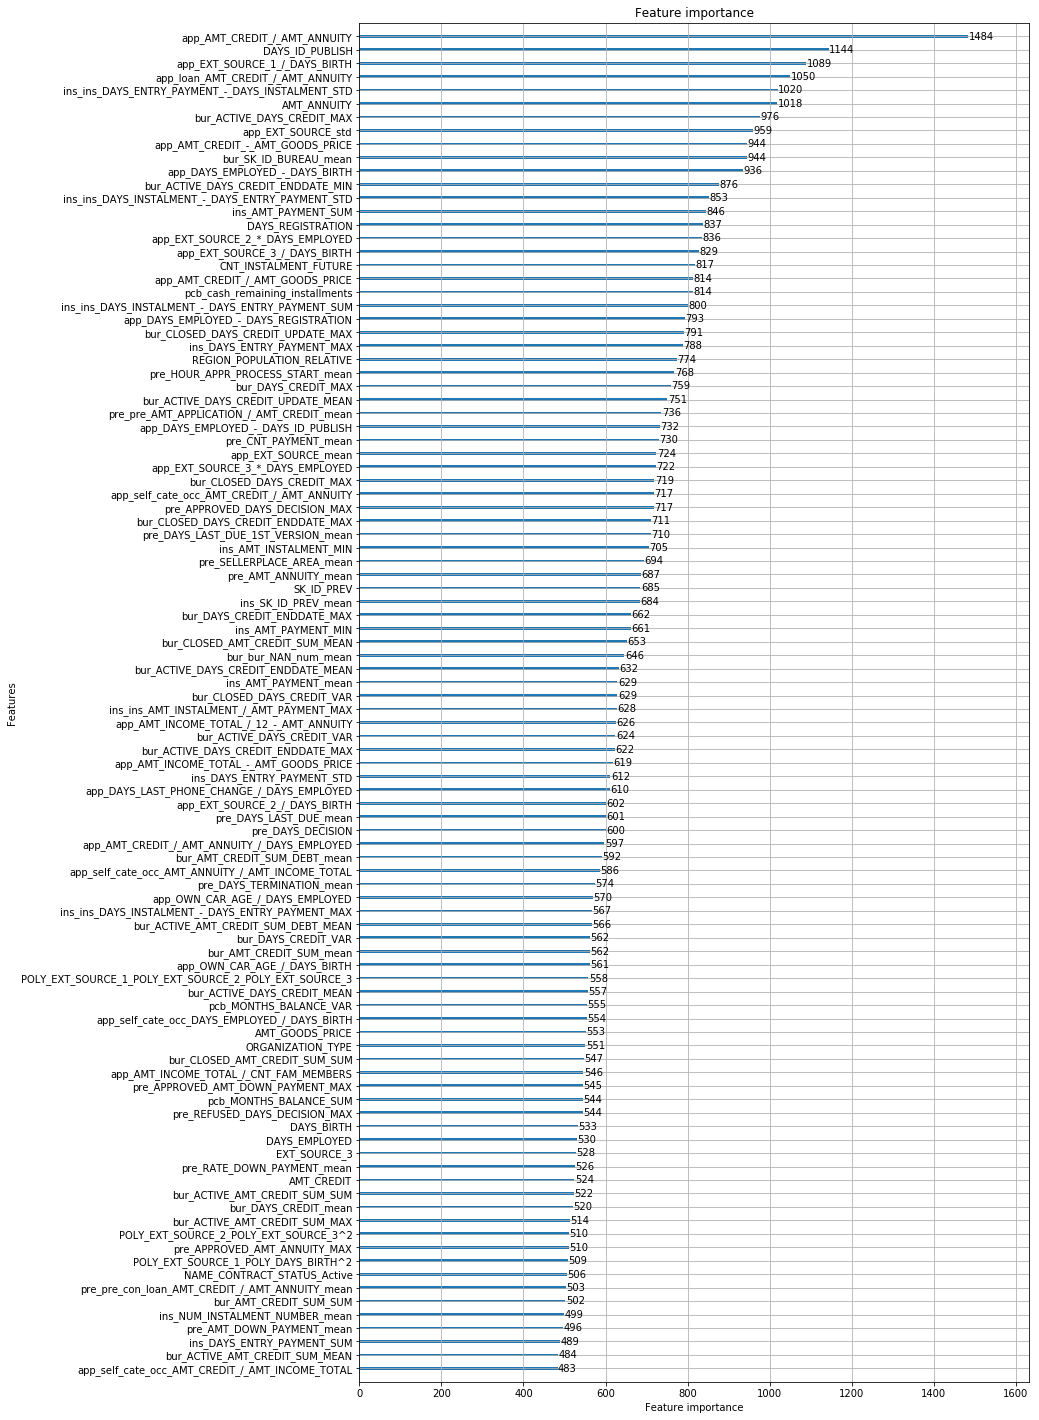

In [37]:
lgb.plot_importance(clf, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [38]:
preds = np.mean(list_preds, axis=0)

#preds = None

    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/14.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.041510
1,100005,0.114062
2,100013,0.019310
3,100028,0.034229
4,100038,0.103915


In [39]:
print('my base lgbm + probause, app domain, poly, data clean, agg feature, category feature')
print(sc_auc_score, ',' ,max_score)

my base lgbm + probause, app domain, poly, data clean, agg feature, category feature
0.7931600616070036 , 0.7966492582520575


In [43]:
print('result: ???')

result: ???


In [41]:
feature_importances_list = []
# 特徴量の表示
for i in range(1, data.shape[1]):
    feature_importances_list.append([data.columns[i], clf.feature_importances_[i-1]])

In [42]:
pd_importancs = pd.DataFrame(feature_importances_list)
pd_importancs.columns = ['features', 'score']
pd_importancs.sort_values('score', ascending=False)
pd_importancs.to_csv('../output/feature_importances.csv')



# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

